Instructions: click restart and run all above. Figures will show once the entire notebook has finished running (will take a few minutes)

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
from tqdm import tqdm
%matplotlib notebook

from membranequant import ImageQuant, direcslist, load_image, af_subtraction, save_img

# ImageQuant class

The previous notebooks have demonstrated a few different models and training conditions. These are all packaged into the ImageQuant class, which lets us run custom analysis with minimal code. This is best demonstrated by way of the examples below. Further examples are demonstrated in these notebooks ([1](./control_n2_quantification.ipynb), [2](./control_response_to_noise.ipynb)), which outline a few control experiments.

Importantly, the class also supports batch quantification (quantifying multiple images in batch), which can massively speed up analysis compared to quantifying single images individually, and allows us to fit global parameters that are shared between many images (sigma, cytbg, membg). The class also contains inbuilt functions that can be used to create figures, and save quantification data in an exportable format. This is all demonstrated below:

## Batch quantification with a 2D model

Here we will perform quantification on a batch of images using the simple 2D model. This will also demonstrate how we can optimise a global sigma parameter by training on multiple images together.

#### Import data

Import and group multiple images and rois together in lists

In [2]:
path = '../test_datasets/dataset2_par2_neon'
paths = direcslist(path)
images = [load_image(p + '/af_corrected.tif') for p in paths]
rois = [np.loadtxt(p + '/ROI.txt') for p in paths]

#### Set up quantifier

The quantifier takes the images and rois we have just imported using the img and roi arguments.

We can specify the model we want using the following parameters:
- sigma: specifies the global value of sigma in the model (or starting condition is this is to be optimised)
- adaptive_sigma: if True, sigma will be optimised to minimise loss across all images. If False, it will be kept at the value specified by the sigma parameter

Other parameters:
- lr and descent_steps: gradient descent parameters (default 0.01 and 1000)
- thickness: thickness of cross section to fit (default 50)
- nfits: number of positions around the circumference of the embryo to fit. Controls the trade off between computational speed and spatial resolution (default 100). If set to None, this will fit positions at pixel width intervals around the cell (like we have done in all of the previous notebooks) but this will not work when quantifying multiple images together as all targets need to be the same size
- iterations: if >1, the algorithm will iteratively refine the ROI, restraighten the images, and re-fit (default 1)
- periodic: set True if ROI is periodic (default True)
- rol_ave: rolling average window, controls trade off between noise and spatial resolution (default 20)

In [3]:
iq = ImageQuant(img=images, roi=rois, thickness=50, periodic=True, rol_ave=20, iterations=2, lr=0.01, descent_steps=1000, nfits=100, sigma=2, adaptive_sigma=True)


#### Run quantification

Run quantification by calling the run function

In [4]:
iq.run()

100%|██████████| 1000/1000 [00:11<00:00, 88.01it/s]

Time elapsed: 22.92 seconds 


#### View loss curves

Loss curve from gradient descent. Each line represents a different image. If iterations are >1, it will only save this for the last iteration. It's useful to check these curves to ensure that gradient descent is smooth, and has stabilised by the end of training (we can see here that it stabilises long before the end)

<IPython.core.display.Javascript object>


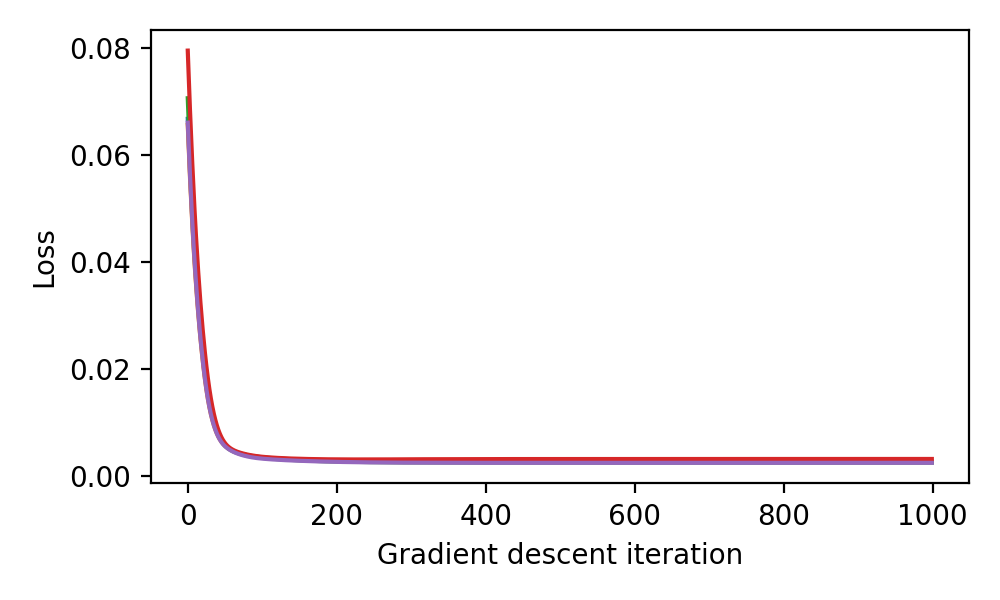

In [5]:
fig, ax = plt.subplots()
ax.plot(iq.losses.T)
ax.set_xlabel('Gradient descent iteration')
ax.set_ylabel('Loss')
fig.set_size_inches(5,3)
fig.tight_layout()

#### Print optimised sigma value

In [6]:
print(iq.sigma)

2.8500776332393936


#### Assess quality of fitting with an interactive figure

We can easily scan through each position of each image, and check that the fitting is appropriate

<IPython.core.display.Javascript object>


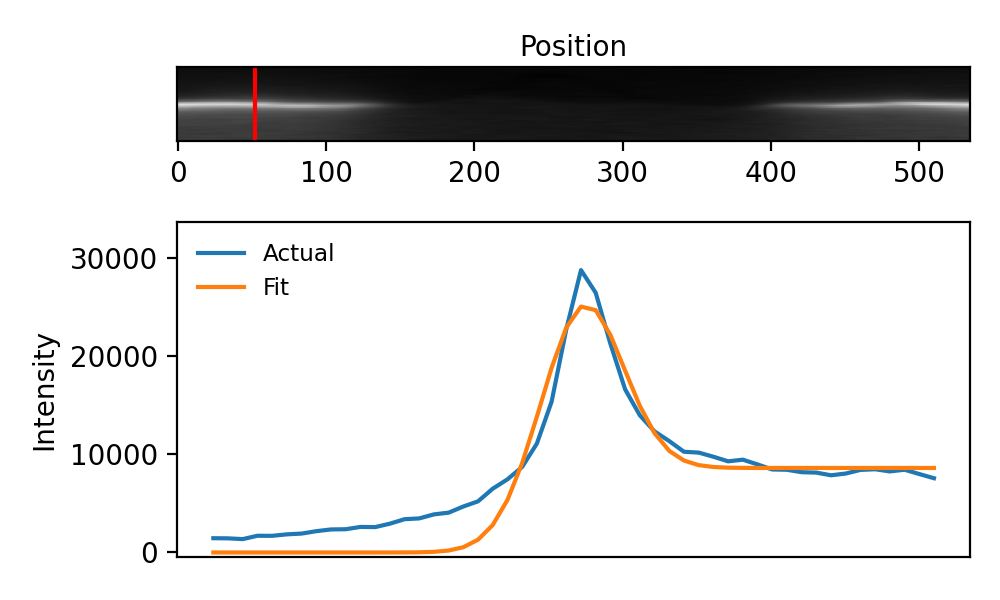

interactive(children=(IntSlider(value=0, description='Frame', max=4), FloatSlider(value=0.1, description='Posi…

In [7]:
iq.plot_fits(jupyter=True)

#### Plot membrane quantification

<IPython.core.display.Javascript object>


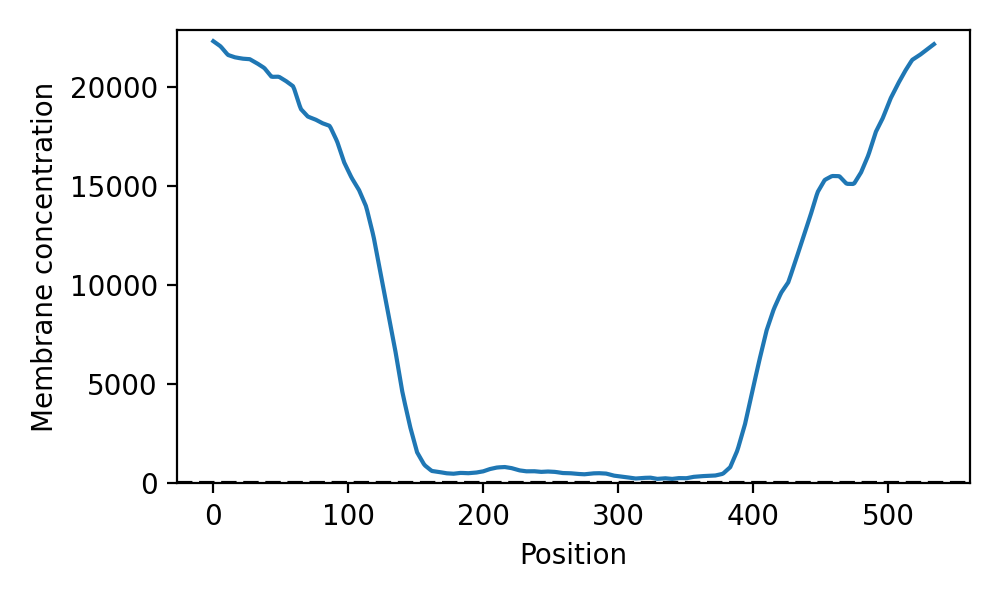

interactive(children=(IntSlider(value=0, description='Frame', max=4), Output()), _dom_classes=('widget-interac…

In [8]:
iq.plot_quantification(jupyter=True)

#### Plot segmentation

If iterations = 1, this will simply show the inputted ROI. If iterations > 1, this will show the refined ROI.

<IPython.core.display.Javascript object>


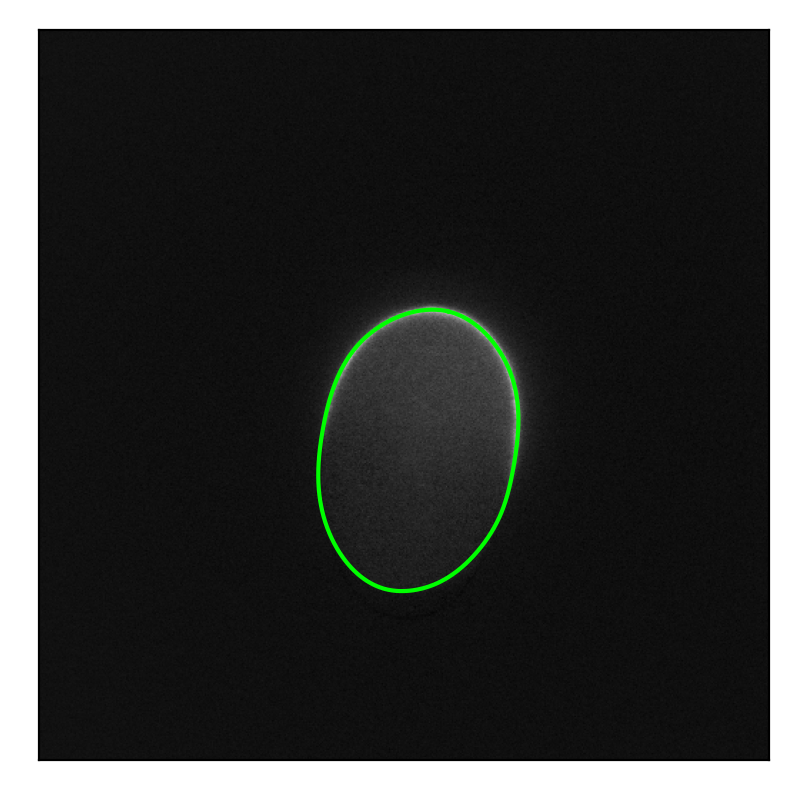

interactive(children=(IntSlider(value=0, description='Frame', max=4), Output()), _dom_classes=('widget-interac…

In [9]:
iq.plot_segmentation(jupyter=True)

#### Export results

Export quantification results as a pandas dataframe. This can be saved as a csv file and imported into another program

In [10]:
res = iq.compile_res()
print(res)
# res.to_csv('...')

    Frame  Position  Membrane signal  Cytoplasmic signal
0       0         0     22288.243593         8558.127984
1       0         1     22026.485523         8676.365619
2       0         2     21595.511891         8673.568804
3       0         3     21472.430328         8685.985085
4       0         4     21408.039350         8676.142026
..    ...       ...              ...                 ...
95      4        95     22375.280607         8399.695721
96      4        96     22783.214110         8495.670358
97      4        97     22767.336511         8652.706467
98      4        98     22225.963194         8862.669837
99      4        99     20890.111805         9116.100590

[500 rows x 4 columns]


## Cytoplasmic reference profile optimisation

Using the same class, we can set up a different model that aims to account for 3D out of focus effects. Here, will will perform training on cytoplasm-only images to generate a cytoplasmic reference profile

#### Import data

In [11]:
path2 = '../test_datasets/dataset3_pkc3_par3mutant'
paths2 = direcslist(path2)
images2 = [load_image(p + '/af_corrected.tif') for p in paths2]
rois2 = [np.loadtxt(p + '/ROI.txt') for p in paths2]

#### Set up quantifier

We can specify the model we want using the following parameters:
- adaptive_cytbg: if True, will optimise the shape of the cytoplasmic reference profile
- uni_cyt: set to True, as cytoplasmic concentrations are uniform
- cyt_only: set to True, as there is only cytoplasmic protein
- cytbg: initial cytoplasmic reference for gradient descent. We will use an error function

Other parameters as above

In [12]:
from scipy.special import erf

sigma = 2
thickness = 50
cytbg = (1 + erf((np.arange(thickness) - thickness / 2) / sigma)) / 2

iq2 = ImageQuant(images2, roi=rois2, cyt_only=True, uni_cyt=True, iterations=2, adaptive_cytbg=True, thickness=thickness, cytbg=cytbg, descent_steps=1000, nfits=100)


#### Run quantification

In [13]:
iq2.run()

100%|██████████| 1000/1000 [00:23<00:00, 42.84it/s]


Time elapsed: 46.28 seconds 


#### Plot the optimised cytoplasmic reference profile

<IPython.core.display.Javascript object>


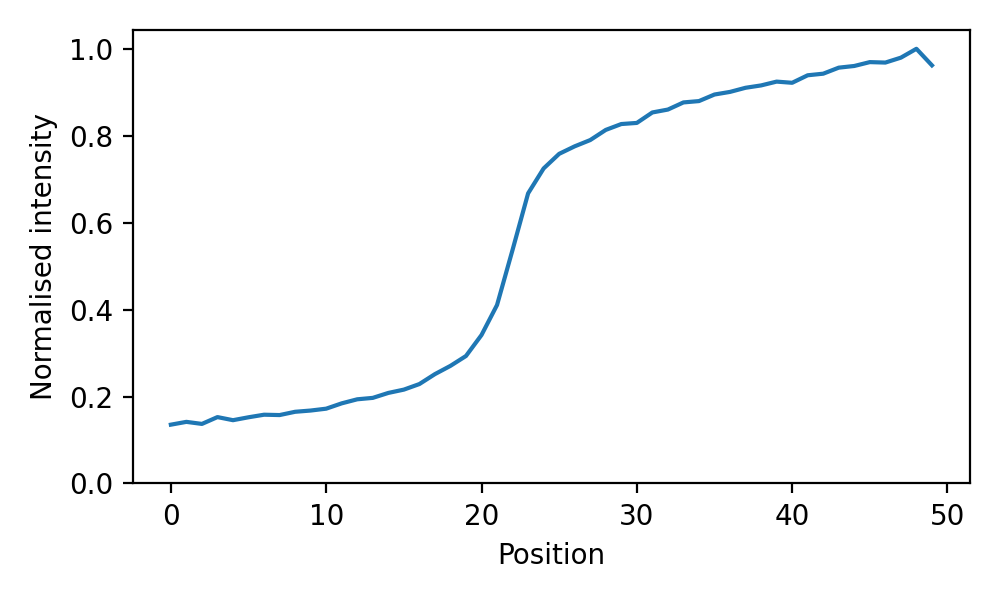

In [14]:
fig, ax = plt.subplots()
cytbg = iq2.cytbg / np.max(iq2.cytbg)
ax.plot(cytbg)
ax.set_xlabel('Position')
ax.set_ylabel('Normalised intensity')
ax.set_ylim(bottom=0)
fig.set_size_inches(5,3)
fig.tight_layout()

## Membrane reference profile optimisation

We can now training the model on images of polarised PAR-2, to generate a membrane reference profile.

#### Import data

In [15]:
path3 = '../test_datasets/dataset2_par2_neon'
paths3 = direcslist(path3)
images3 = [load_image(p + '/af_corrected.tif') for p in paths3]
rois3 = [np.loadtxt(p + '/ROI.txt') for p in paths3]

#### Set up quantifier

We can specify the model we want using the following parameters:
- adaptive_membg: set to True
- membg: initial conditions for optimisation. We will use a Gaussian
- uni_cyt: set to True, as cytoplasmic concentrations are uniform
- cytbg: cytoplasmic reference profile. We will use the one generated above, and keep this fixed (adaptive_cytbg=False)

Other parameters as above

In [16]:
sigma = 2
thickness = 50
membg = np.exp(-((np.arange(thickness) - thickness / 2) ** 2) / (2 * sigma ** 2))

iq3 = ImageQuant(images3, roi=rois3, iterations=2, adaptive_membg=True, thickness=50, cytbg=cytbg, membg=membg, descent_steps=1000, uni_cyt=True, nfits=100)


#### Run quantification

In [17]:
iq3.run()

100%|██████████| 1000/1000 [00:28<00:00, 34.95it/s]

Time elapsed: 57.76 seconds 


#### Plot the optimised membrane reference profile

<IPython.core.display.Javascript object>


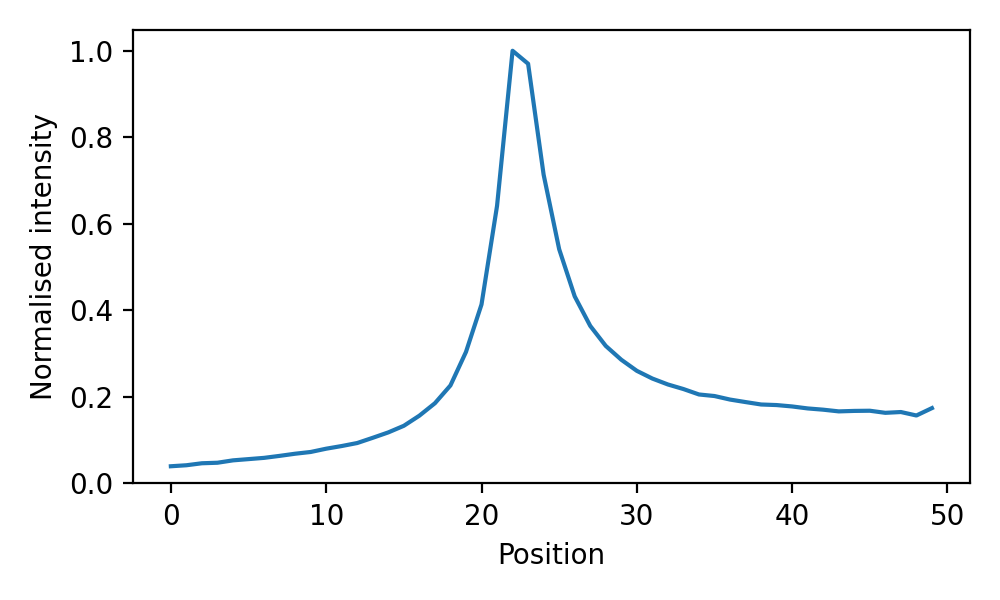

In [21]:
fig, ax = plt.subplots()
membg = iq3.membg / np.max(iq3.membg)
ax.plot(membg)
ax.set_xlabel('Position')
ax.set_ylabel('Normalised intensity')
fig.set_size_inches(5,3)
ax.set_ylim(bottom=0)
fig.tight_layout()

#### Plot membrane quantification with the optimised model

<IPython.core.display.Javascript object>


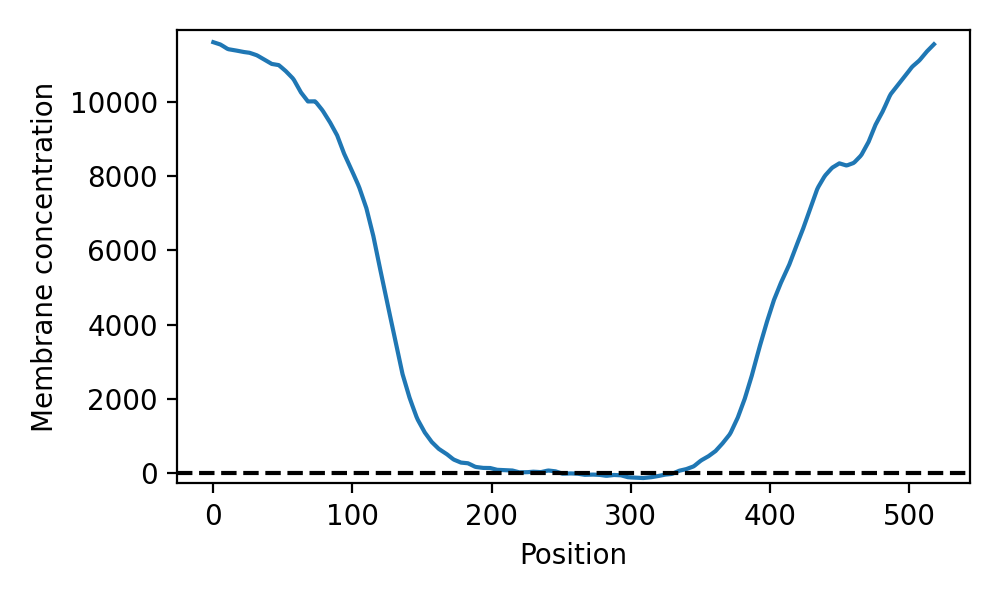

interactive(children=(IntSlider(value=0, description='Frame', max=4), Output()), _dom_classes=('widget-interac…

In [19]:
iq3.plot_quantification(jupyter=True)

#### Save optimised model

In [20]:
np.savetxt('saved_cyt_ref_profile.txt', cytbg)
np.savetxt('saved_mem_ref_profile.txt', membg)

## Graphical user interface